In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
!pip install matplotlib-venn -q
from matplotlib_venn import venn2
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# Разработка A/B-тестирования и анализ результатов

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении компании существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Моя задача -  помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Будем работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### Работа с историческими данными (EDA)

#### Загрузка исторических данных
На первом этапе рассмотрим исторические данные приложения.

In [2]:
# Выгружаем данные 
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
# Выводим первые строки датафрейма на экран
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Выводим информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


**Датасет `sessions_history` содержит 10 столбцов и 435924 строк**, в которых представлены данные о сессиях пользователей приложения в период с 11.08.2025 по 23.09.2025.

1. Типы данных в целом заданы верно, но можно провести оптимизацию:
 - `region`, `device` для экономии памяти и упрощения группировок можно перевести в тип category.
 - `session_date`, `session_start_ts`, `install_date` следует привести к типу datetime, чтобы анализировать активность по времени.

2. Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.

3. Пропусков в данных нет. Все 10 столбцов полностью заполнены.


In [5]:
# Проверяем уникальные значения в столбцах
for column in ['registration_flag', 'region', 'device', 'page_counter']:
    print(f'Уникальные значения в столбце {column}:')
    print(sessions_history[column].sort_values().unique())
    print()

Уникальные значения в столбце registration_flag:
[0 1]

Уникальные значения в столбце region:
['CIS' 'EU' 'MENA']

Уникальные значения в столбце device:
['Android' 'Mac' 'PC' 'iPhone']

Уникальные значения в столбце page_counter:
[1 2 3 4 5 6 7]



Все столбцы содержат корректные и ограниченные наборы категориальных значений.
Аномалий, пустых значений или неверных категорий не выявлено.

Выполним проверку на наличие полных дубликатов записей.

In [6]:
# Проверяем полные дубликаты в sessions_history
print(f"Полных дубликатов в датафрейме sessions_history: {sessions_history.duplicated().sum()}")

Полных дубликатов в датафрейме sessions_history: 0


Выполним проверку на наличие неявных дубликатов записей по сочетанию столбцов user_id и session_id.

In [7]:
# Отсортируем датафрейм по всем столбцам в порядке возрастания с помощью метода sort_values()
sessions_history_sorted = sessions_history.sort_values(by = sessions_history.columns.tolist())

In [8]:
# Найдем неявные дубликаты в столбцах user_id и session_id с помощью метода duplicated() 
duplicates_user_session = sessions_history_sorted.duplicated(subset=['user_id', 'session_id'], keep = False)
print(f"Неявных дубликатов (по сочетанию user_id и session_id): {duplicates_user_session.sum()}")

Неявных дубликатов (по сочетанию user_id и session_id): 0


Дубликатов в таблице `sessions_history` не обнаружено.

#### Знакомство с данными


Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

In [9]:
# Считаем количество уникальных сессий на пользователя
sessions_per_user = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()
display(sessions_per_user)

,user_id,session_id
0,00005FB6A13A6FBE,2
1,0000B15A18D77ED9,3
2,0000C4E3A4A571A9,2
3,000293FAF9E67A81,4
4,00029C5AE889A6C3,2
...,...,...
134034,FFFCDE7746148710,4
134035,FFFDD413285E753F,3
134036,FFFECBA0F2578AB0,2
134037,FFFEDB68228B5F21,5


Выведем на экран все данные из таблицы `sessions_history` для пользователя с наибольшим количеством сессий.

In [10]:
# Находим пользователя с максимальным числом сессий
max_sessions_user = sessions_per_user.sort_values('session_id', ascending=False).iloc[0]['user_id']

print(f"Пользователь с наибольшим количеством сессий: {max_sessions_user}")

Пользователь с наибольшим количеством сессий: 10E0DEFC1ABDBBE0


In [11]:
# Выводим все данные по этому пользователю
user_data = sessions_history[sessions_history['user_id'] == max_sessions_user]
display(user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


1. Общее количество сессий:
пользователь имеет 10 сессий, что является максимальным значением среди всех пользователей. Это указывает на высокую вовлечённость — пользователь активно возвращается в приложение почти ежедневно.

2. Даты сессий:
первая установка — 2025-08-14.
Сессии происходят ежедневно с 14 по 25 августа 2025 года, за исключением 21 и 23 августа.

3. Регистрация:
registration_flag = 0 во всех строках.
Пользователь не зарегистрировался, несмотря на активное использование.

4. Количество просмотренных страниц:
значения колеблются от 1 до 4, без выраженного роста или снижения.

5. Регион и устройство:
 - Регион — CIS.
 - Устройство — Android.

Вывод: пользователь активно использует приложение, но не зарегистрировался и проявляет умеренную вовлечённость. Это может указывать на интерес к продукту без сильной привязанности или проблемы в пользовательском пути (например, неудобная регистрация, непонятные шаги).

#### Анализ числа регистраций


Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя данные из таблицы `sessions_history`, проанализируем как менялось число регистраций в приложении за время его существования.

In [12]:
# Преобразуем столбец 'session_date' в формате даты
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

Сгруппируем и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

In [13]:
# Количество всех уникальных пользователей по дням
unique_users = sessions_history.groupby('session_date')['user_id'].nunique().reset_index().rename(columns={'user_id': 'unique_users'})

In [14]:
# Количество зарегистрированных пользователей по дням
registered_users = sessions_history.query('registration_flag == 1').groupby('session_date')['user_id'].nunique().reset_index().rename(columns={'user_id': 'registered_users'})

In [15]:
# Объединяем обе таблицы по дате
daily_stats = unique_users.merge(registered_users, on='session_date', how='left')

In [16]:
# Добавим столбец с долей зарегистрированных пользователей
daily_stats['registered_share'] = daily_stats['registered_users'] / daily_stats['unique_users']

In [17]:
# Вывод на экран
daily_stats.head(10)

,session_date,unique_users,registered_users,registered_share
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723
5,2025-08-16,12205,916,0.075051
6,2025-08-17,11200,833,0.074375
7,2025-08-18,10839,860,0.079343
8,2025-08-19,12118,831,0.068576
9,2025-08-20,13514,1008,0.074589


На основе получившейся таблицы построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням, а также линейный график доли зарегистрированных пользователей от всех пользователей по дням.

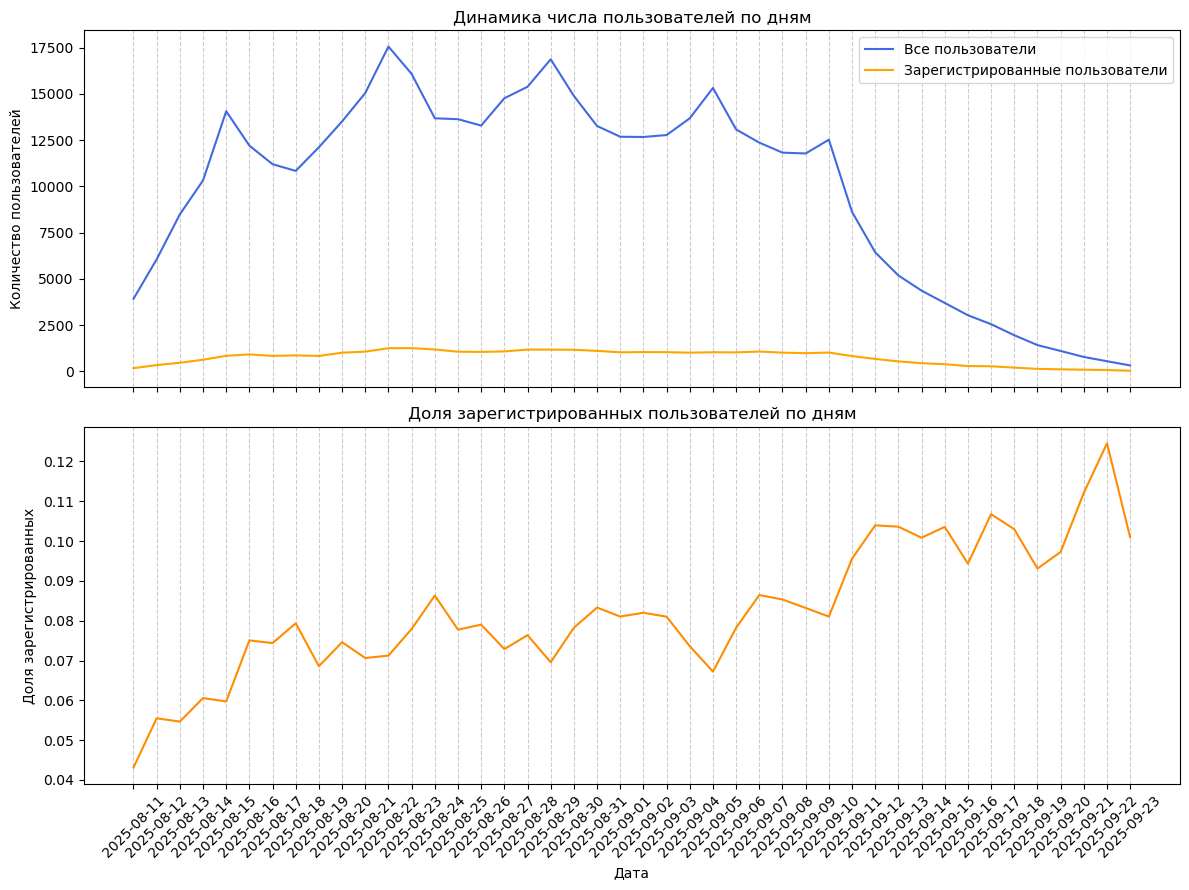

In [18]:
# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Строим графики общего числа пользователей и общего числа зарегистрированных пользователей по дням
axes[0].plot(daily_stats['session_date'], daily_stats['unique_users'], linestyle='-', color='royalblue', label='Все пользователи')
axes[0].plot(daily_stats['session_date'], daily_stats['registered_users'], linestyle='-', color='orange', label='Зарегистрированные пользователи')

# Настраиваем оформление графика
axes[0].set_title('Динамика числа пользователей по дням')
axes[0].set_ylabel('Количество пользователей')
axes[0].grid(True, axis='x', color='gray', linestyle='--', alpha=0.4)
axes[0].legend(loc='upper right')

# Строим график доли зарегистрированных пользователей от всех пользователей по дням
axes[1].plot(daily_stats['session_date'], daily_stats['registered_share'], linestyle='-', color='darkorange')

# Настраиваем оформление графика
axes[1].set_title('Доля зарегистрированных пользователей по дням')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Доля зарегистрированных')
axes[1].grid(True, axis='x', color='gray', linestyle='--', alpha=0.4)
plt.xticks(daily_stats['session_date'], rotation=45)

# Выводим графики
plt.tight_layout()
plt.show()

Общая динамика уникальных пользователей и зарегистрированных пользователей
 - В первые дни (11–15 августа) наблюдается стремительный рост уникальных пользователей: с 3919 до 14 065.
 - Число зарегистрированных пользователей также растет, но заметно медленнее, доля регистраций 4–6% в начале.
 - Пик по количеству уникальных пользователей пришёлся на 22 августа (17 563), после чего начинается колебательная тенденция с постепенным снижением.
 - Число зарегистрированных пользователей растет более равномерно и менее резко, чем общее число пользователей.

Вывод: приложение в первые дни привлекло много новых пользователей, вероятно, это связано с высокой маркетинговой активностью или вирусным эффектом, но пользователи сначала “зашли и посмотрели”, а не регистрировались сразу.

Доля зарегистрированных пользователей
 - В начале доля зарегистрированных пользователей была очень низкой: около 4–6 %.
 - Начиная с 16 августа, наблюдается рост доли регистраций до 7–8 %.
 - Пик доли приходится на конец периода (21–23 сентября), когда доля зарегистрированных пользователей достигает 10–12%. При этом общее число пользователей в этот период снижается, что говорит о том, что активность осталась у более лояльной аудитории.

Вывод: доля зарегистрированных растет по мере снижения общего числа пользователей — это классическая картина “отсева случайных или новых пользователей”, остаются только более заинтересованные.

#### Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.


Найдем количество сессий для каждого значения количества просмотренных страниц и на основе этих данных построим столбчатую диаграмму.

In [19]:
# Считаем количество сессий для каждого количества просмотренных страниц
page_counts = sessions_history.groupby('page_counter')['session_id'].count().reset_index().sort_values('page_counter')

In [20]:
# Вывод на экран
display(page_counts)

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


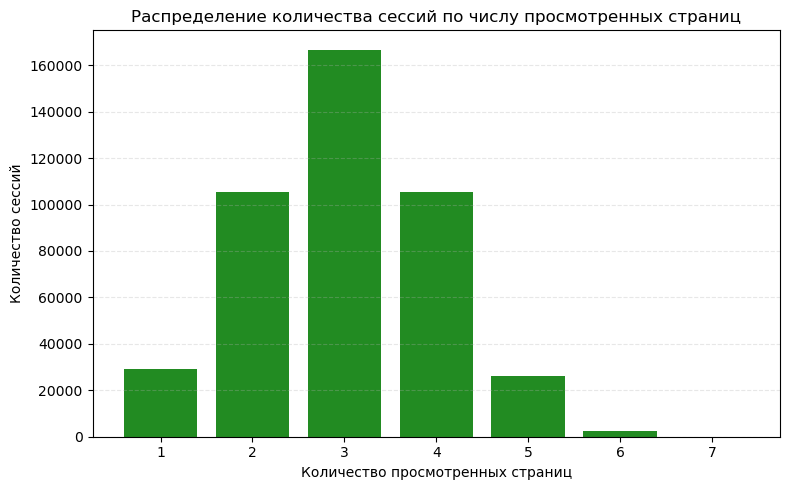

In [21]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(8, 5))

# Строим стобчатую диаграмму
plt.bar(page_counts['page_counter'], page_counts['session_id'], color='forestgreen')

# Настраиваем оформление графика
plt.title('Распределение количества сессий по числу просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Пользователь обычно просматривает 2–4 страницы.
 - Пик приходится на 3 страницы — это средний уровень вовлечённости.
 - Очень высокий просмотр страниц встречается редко, что типично для большинства приложений

#### Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.


В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если было просмотрено меньше.

In [22]:
# Добавляем столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

In [23]:
# Проверим результат
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


Найдем средние значения доли успешных сессий от всех сессий по дням за весь период наблюдения и на основе этих данных построим линейный график с линией среднего значения за весь период.

In [24]:
# Группируем по дате и считаем среднее значение good_session
daily_good_sessions = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

In [25]:
# Вывод на экран
daily_good_sessions.head()

,session_date,good_session
0,2025-08-11,0.312835
1,2025-08-12,0.302015
2,2025-08-13,0.306750
3,2025-08-14,0.316055
4,2025-08-15,0.304941


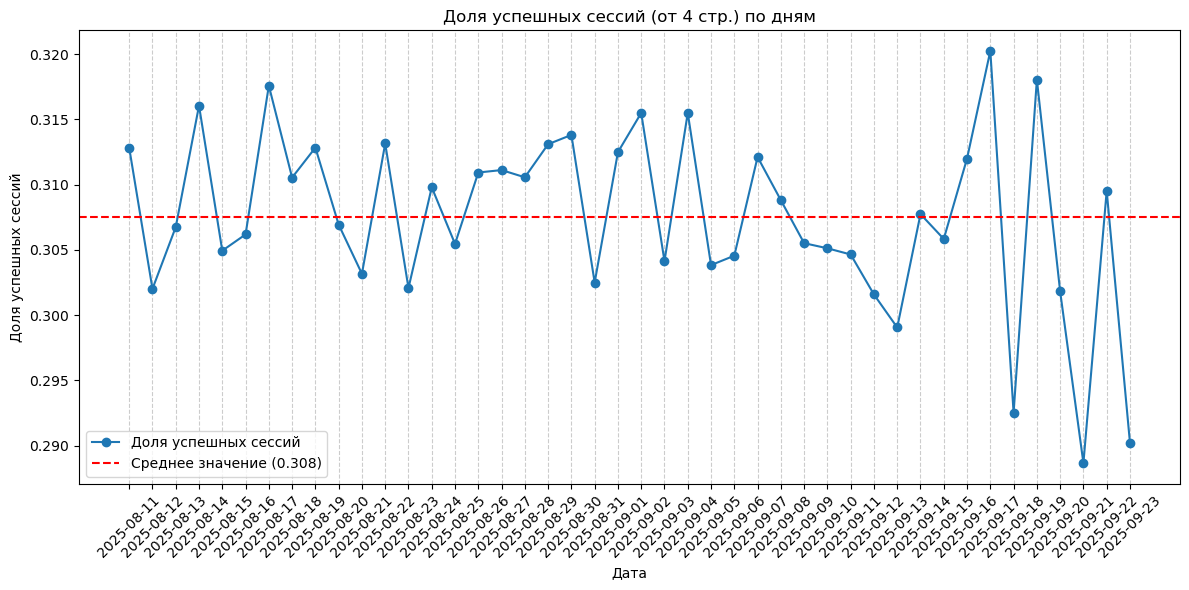

In [26]:
# Среднее значение доли успешных сессий
mean_good = daily_good_sessions['good_session'].mean()

# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(12,6))

# Строим линейный график с линией среднего значения
plt.plot(daily_good_sessions['session_date'], daily_good_sessions['good_session'], marker='o', label='Доля успешных сессий')
plt.axhline(mean_good, color='red', linestyle='--', label=f'Среднее значение ({mean_good:.3f})')

# Настраиваем оформление графика
plt.title('Доля успешных сессий (от 4 стр.) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(daily_good_sessions['session_date'], rotation=45)
plt.grid(True, axis='x', color='gray', linestyle='--', alpha=0.4)
plt.legend(loc='lower left')

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Значения колеблются в диапазоне примерно 0.288–0.320, т.е. 28–32 % всех сессий можно считать успешными.
 - Наибольшие значения доли успешных сессий наблюдаются 17 сентября (0.320) и 19 сентября (0.318).
 - Минимальные значения — 21 сентября (0.289) и 18 сентября (0.293), что может указывать на снижение вовлечённости в эти дни.

В целом, доля успешных сессий достаточно стабильна, колебания не превышают 3 % относительно среднего уровня (0.308).

### Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### Формулировка нулевой и альтернативной гипотез

Изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

Определим целевую метрику и сформулируем нулевую и альтернативную гипотезы.

 - Целевая метрика: доля успешных сессий. Сессия считается успешной (good_session = 1), если пользователь просмотрел 4 и более страниц. Эта метрика отражает вовлечённость пользователей и удовлетворённость контентом.

 - Нулевая гипотеза: p_a = p_b

Новый алгоритм не влияет на вовлечённость пользователей.
Средняя доля успешных сессий в тестовой группе равна доле успешных сессий в контрольной группе.

 - Альтернативная гипотеза: p_a < p_b

Новый алгоритм повышает вовлечённость пользователей. Средняя доля успешных сессий в тестовой группе выше, чем в контрольной.

 - Тип гипотезы: Односторонняя (правосторонняя)

#### Расчёт размера выборки


Рассчитаем необходимое количество пользователей для эксперимента с помощью метода `solve_power()` из класса power.NormalIndPower модуля statsmodels.stats.

Для этого установим следующие параметры:
- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста - 0.8.
- Минимальный детектируемый эффект, или MDE, — 3%

In [27]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta   # Мощность теста
p = 0.3 # Базовый уровень доли успешных сессий (4+ стр.)
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


С использованием функции `NormalIndPower.solve_power()` было определено, что для обнаружения минимального эффекта размером 3% при уровне значимости 5% и мощности 80% **требуется по 41 040 наблюдений в каждой группе**.

#### Расчёт длительности A/B-теста


Рассчитаем длительность теста, используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения.

In [28]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней.")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9908 пользователей в день составит 9 дней.


 - При текущем уровне трафика в 9 908 пользователей в день **расчётная длительность A/B-теста составляет 9 дней**.
 - Однако, чтобы учесть влияние сезонных колебаний и внешних факторов и получить более надёжные результаты, **целесообразно увеличить продолжительность эксперимента до 14 дней** (двух полных недель).

## Мониторинг А/В-теста

### Проверка распределения пользователей


A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие метрики корректно считаются.

Рассмотрим данные за первый день проведения А/В-теста.

In [29]:
# Выгружаем данные
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [30]:
# Выводим информацию о датафрейме
sessions_test_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


In [31]:
# Проверяем уникальные значения в столбцах
for column in ['registration_flag', 'region', 'device', 'page_counter', 'test_group']:
    print(f'Уникальные значения в столбце {column}:')
    print(sessions_test_part[column].sort_values().unique())
    print()

Уникальные значения в столбце registration_flag:
[0 1]

Уникальные значения в столбце region:
['CIS' 'EU' 'MENA']

Уникальные значения в столбце device:
['Android' 'Mac' 'PC' 'iPhone']

Уникальные значения в столбце page_counter:
[1 2 3 4 5 6 7]

Уникальные значения в столбце test_group:
['A' 'B']



In [32]:
# Проверяем полные дубликаты в sessions_test_part
print(f"Полных дубликатов в датафрейме sessions_test_part: {sessions_test_part.duplicated().sum()}")

Полных дубликатов в датафрейме sessions_test_part: 0


In [33]:
# Отсортируем датафрейм по всем столбцам в порядке возрастания с помощью метода sort_values()
sessions_test_part_sorted = sessions_test_part.sort_values(by = sessions_test_part.columns.tolist())

In [34]:
# Найдем неявные дубликаты в столбцах user_id и session_id с помощью метода duplicated() 
duplicates_user_session_test_part = sessions_test_part_sorted.duplicated(subset=['user_id', 'session_id'], keep = False)
print(f"Неявных дубликатов (по сочетанию user_id и session_id): {duplicates_user_session_test_part.sum()}")

Неявных дубликатов (по сочетанию user_id и session_id): 0


Установлено:
- Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.
- Все столбцы содержат корректные и ограниченные наборы категориальных значений. Аномалий, пустых значений или неверных категорий не выявлено.
- Дубликатов не обнаружено.

Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения и на основе этих данных построим столбчатую диаграмму.

In [35]:
# Считаем количество уникальных пользователей в каждой группе
users_per_group = sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index().rename(columns={'user_id': 'unique_users'})

In [36]:
# Вывод на экран
print("Количество уникальных пользователей в каждой группе:")
display(users_per_group)

Количество уникальных пользователей в каждой группе:


,test_group,unique_users
0,A,1477
1,B,1466


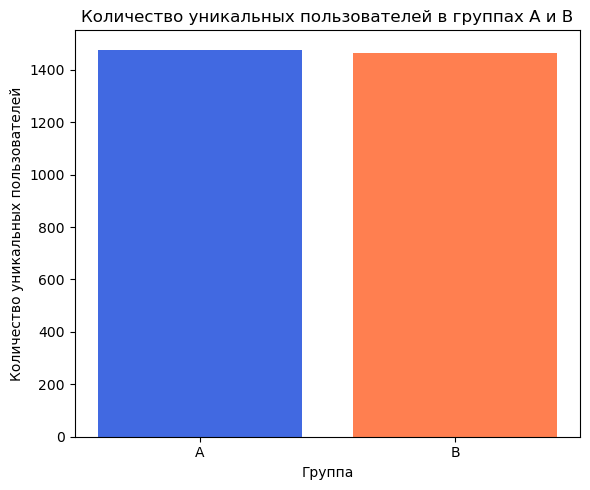

In [37]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(6, 5))

# Строим стобчатую диаграмму
plt.bar(users_per_group['test_group'], users_per_group['unique_users'], color=['royalblue', 'coral'])

# Настраиваем оформление графика
plt.title('Количество уникальных пользователей в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')

# Выводим график
plt.tight_layout()
plt.show()

Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B.

In [38]:
# Рассчитываем процентную разницу между группами
a_users = users_per_group.loc[users_per_group['test_group'] == 'A', 'unique_users'].values[0]
b_users = users_per_group.loc[users_per_group['test_group'] == 'B', 'unique_users'].values[0]

percent_diff = round(100 * (abs(a_users - b_users) / a_users),2)

print(f"Процентная разница между группами A и B составляет {percent_diff}%")

Процентная разница между группами A и B составляет 0.74%


Разница в численности пользователей между группами A и B составляет менее 1%, что **указывает на их равномерное распределение**.

### Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B (или найдем, что таких нет).

In [39]:
# Разделим пользователей по группам
users_group_a = set(sessions_test_part.loc[sessions_test_part['test_group'] == 'A', 'user_id'])
users_group_b = set(sessions_test_part.loc[sessions_test_part['test_group'] == 'B', 'user_id'])

In [40]:
# Найдём пересечение пользователей, попавших в обе группы
overlap_users = users_group_a.intersection(users_group_b)

In [41]:
# Выводим результаты
if len(overlap_users) == 0:
    print("Группы независимы: пересечений пользователей нет.")
else:
    print(f"Найдено {len(overlap_users)} пользователей, попавших одновременно в группы A и B.")

Группы независимы: пересечений пользователей нет.


Визуализируем пересечение пользователей с помощью диаграммы Венна.

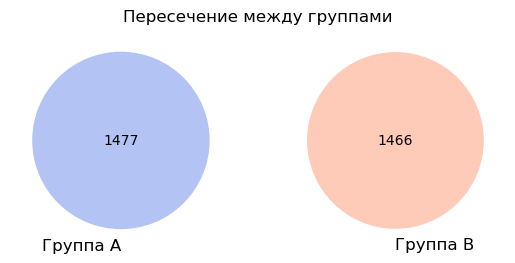

In [42]:
first_id = set(sessions_test_part.loc[sessions_test_part['test_group'] == 'A', 'user_id'])
second_id = set(sessions_test_part.loc[sessions_test_part['test_group'] == 'B', 'user_id'])
# Строим диаграмму Венна
venn2([first_id, second_id], set_labels=('Группа А', 'Группа В'), set_colors=('royalblue', 'coral'))

# Отображаем график
plt.title("Пересечение между группами")
plt.show()

Пересечений между пользователями групп не выявлено, следовательно, **группы можно считать независимыми**.

### Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.


Выполним группировку данных по тестовой группе и типу устройства с расчётом числа уникальных пользователей в каждой категории.

In [43]:
# Группируем данные по типу устройства и группе теста
device_dist = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})

In [44]:
# Добавляем столбец с процентом пользователей по каждому устройству в пределах группы
device_dist['percent'] = round(device_dist['users'] / device_dist.groupby('test_group')['users'].transform('sum') * 100,2)

In [45]:
# Вывод на экран
display(device_dist)

,test_group,device,users,percent
0,A,Android,656,44.41
1,A,Mac,156,10.56
2,A,PC,369,24.98
3,A,iPhone,296,20.04
4,B,Android,668,45.57
5,B,Mac,148,10.10
6,B,PC,381,25.99
7,B,iPhone,269,18.35


Построим две диаграммы:
- доля каждого типа устройства для пользователей из группы A,
- доля каждого типа устройства для пользователей из группы B.

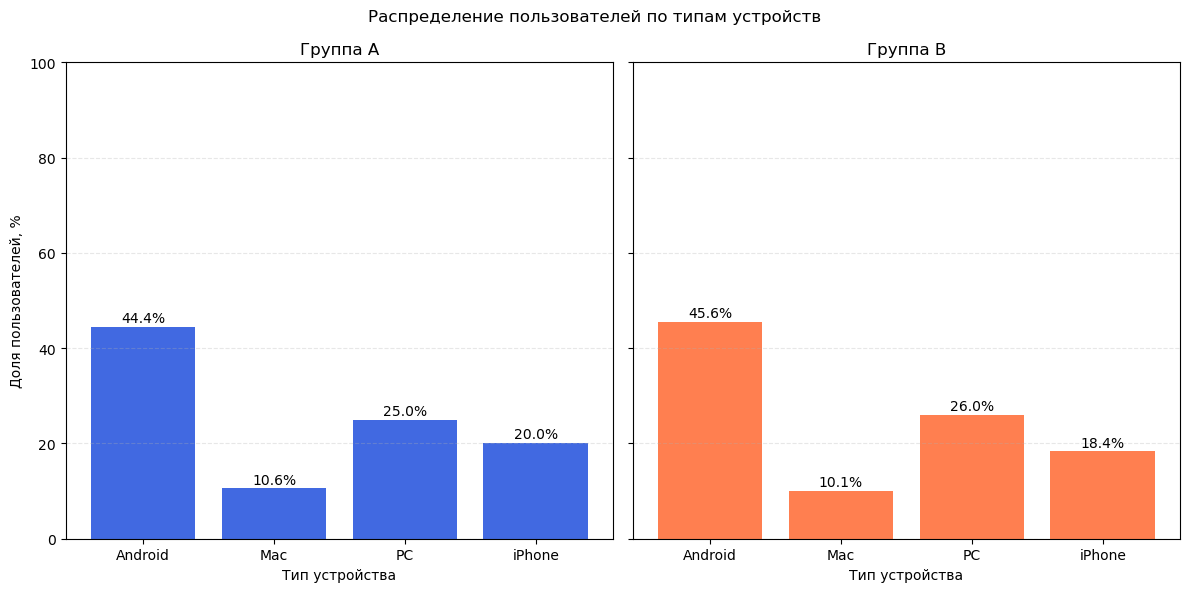

In [46]:
# Разделяем данные по группам A и B
device_a = device_dist[device_dist['test_group'] == 'A']
device_b = device_dist[device_dist['test_group'] == 'B']

# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Строим диаграмму (группа A)
axes[0].bar(device_a['device'], device_a['percent'], color='royalblue')

# Настраиваем оформление графика (группа A)
axes[0].set_title('Группа A')
axes[0].set_xlabel('Тип устройства')
axes[0].set_ylabel('Доля пользователей, %')
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(device_a['percent']):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# Строим диаграмму
axes[1].bar(device_b['device'], device_b['percent'], color='coral')

# Настраиваем оформление графика (группа B)
axes[1].set_title('Группа B')
axes[1].set_xlabel('Тип устройства')
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(device_b['percent']):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# Настраиваем оформление графика
plt.suptitle('Распределение пользователей по типам устройств')

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Распределение пользователей по тестовым группам и типам устройств является равномерным - доли пользователей на каждой платформе практически совпадают между группами A и B (разница по долям не превышает 1–2%).
 - Основная часть пользователей приложения использует Android (45%).

### Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.


Выполним группировку данных по тестовой группе и региону с расчётом числа уникальных пользователей в каждой категории.

In [47]:
# Группируем данные по регионам и группам
region_dist = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})

In [48]:
# Добавляем столбец с процентом пользователей по каждому устройству в пределах группы
region_dist['percent'] = round(region_dist['users'] / region_dist.groupby('test_group')['users'].transform('sum') * 100,2)

In [49]:
# Вывод на экран
display(region_dist)

,test_group,region,users,percent
0,A,CIS,644,43.60
1,A,EU,224,15.17
2,A,MENA,609,41.23
3,B,CIS,645,44.00
4,B,EU,217,14.80
5,B,MENA,604,41.20


Построим две диаграммы:
 - доля каждого региона для пользователей из группы A,
 - доля каждого региона для пользователей из группы B.

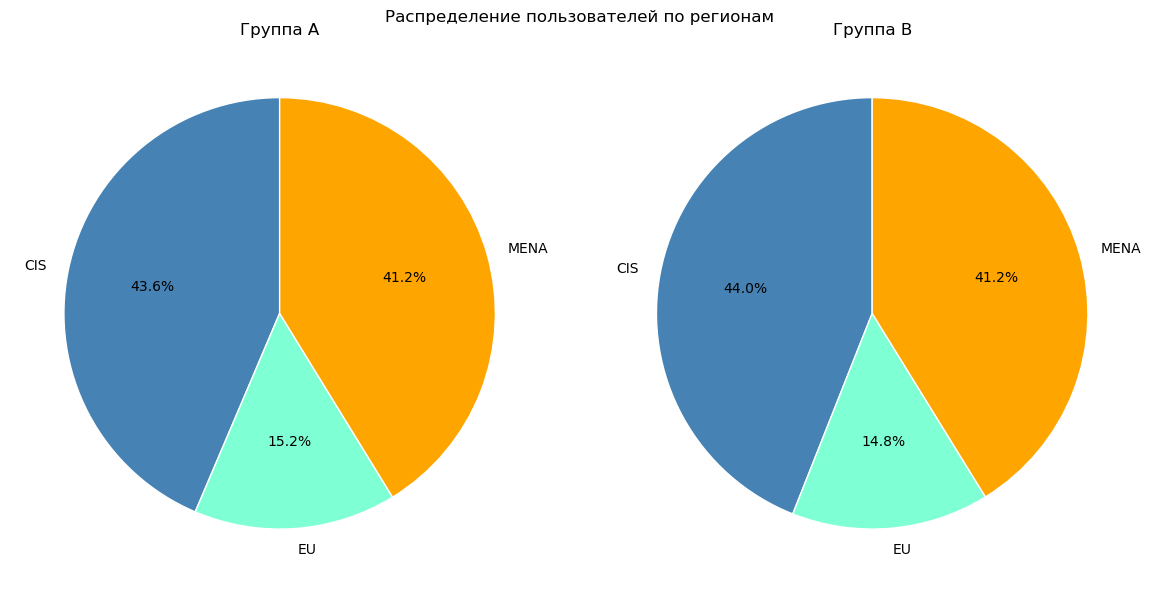

In [50]:
# Разделяем данные по группам A и B
region_a = region_dist[region_dist['test_group'] == 'A']
region_b = region_dist[region_dist['test_group'] == 'B']

# Создаём контейнер для графиков и задаём размер области вывода
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Строим диаграмму (группа A)
axes[0].pie(
    region_a['percent'],
    labels=region_a['region'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['steelblue', 'aquamarine', 'orange'],
    wedgeprops={'edgecolor': 'white'})

# Строим диаграмму (группа В)
axes[1].pie(
    region_b['percent'],
    labels=region_b['region'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['steelblue', 'aquamarine', 'orange'],
    wedgeprops={'edgecolor': 'white'})

# Настраиваем оформление графика
axes[0].set_title('Группа A')
axes[1].set_title('Группа B')
plt.suptitle('Распределение пользователей по регионам')

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**
 - Равномерное распределение по регионам подтверждается — разница между группами минимальна.
 - Основная часть пользователей приложения находится в регионах CIS и MENA (по 41–44% каждая).

### Вывод после проверки A/B-теста


Мониторинг A/B-теста показал, что:

1. Контрольная и тестовая группы сбалансированы по количеству пользователей.

2. Выборки независимы, пересечения нет.

3. Равномерное распределение по ключевым категориальным переменным (устройства, регионы) сохраняется.

**A/B-тест проводится корректно, нарушений в рандомизации и распределении пользователей не обнаружено.**

## Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

### Получение результатов теста и подсчёт основной метрики


Рассмотрим данные за весь период проведения А/В-теста.

In [51]:
# Выгружаем данные за все дни проведения эксперимента
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [52]:
# Выводим информацию о датафрейме
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


In [53]:
# Проверяем уникальные значения в столбцах
for column in ['registration_flag', 'region', 'device', 'page_counter', 'test_group']:
    print(f'Уникальные значения в столбце {column}:')
    print(sessions_test[column].sort_values().unique())
    print()

Уникальные значения в столбце registration_flag:
[0 1]

Уникальные значения в столбце region:
['CIS' 'EU' 'MENA']

Уникальные значения в столбце device:
['Android' 'Mac' 'PC' 'iPhone']

Уникальные значения в столбце page_counter:
[1 2 3 4 5 6 7]

Уникальные значения в столбце test_group:
['A' 'B']



In [54]:
# Проверяем полные дубликаты в sessions_test
print(f"Полных дубликатов в датафрейме sessions_test: {sessions_test.duplicated().sum()}")

Полных дубликатов в датафрейме sessions_test: 0


In [55]:
# Отсортируем датафрейм по всем столбцам в порядке возрастания с помощью метода sort_values()
sessions_test_sorted = sessions_test.sort_values(by = sessions_test.columns.tolist())

In [56]:
# Найдем неявные дубликаты в столбцах user_id и session_id с помощью метода duplicated() 
duplicates_user_session_test = sessions_test_sorted.duplicated(subset=['user_id', 'session_id'], keep = False)
print(f"Неявных дубликатов (по сочетанию user_id и session_id): {duplicates_user_session_test.sum()}")

Неявных дубликатов (по сочетанию user_id и session_id): 0


Установлено:
 - Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.
 - Все столбцы содержат корректные и ограниченные наборы категориальных значений. Аномалий, пустых значений или неверных категорий не выявлено.
 - Дубликатов не обнаружено.

В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если просмотрено меньше.

In [57]:
# Создаём новый столбец good_session:
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Проверяем результат
display(sessions_test.head(10))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
5,31F7A42B32103403,E9B64B779C3348ED,2025-10-20,2025-10-20 17:09:41,2025-10-19,2,0,2,CIS,PC,B,0
6,87C09E3E3B334959,FECFF83C13DC9364,2025-10-22,2025-10-22 23:51:42,2025-10-20,3,0,4,CIS,iPhone,B,1
7,457F2674E87EF6E7,14F71C18BE2CEC08,2025-10-19,2025-10-19 11:49:11,2025-10-19,1,0,3,MENA,Mac,A,0
8,57F342451921D207,76EFA055599ADE3C,2025-10-19,2025-10-19 18:47:43,2025-10-19,1,0,3,CIS,PC,A,0
9,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B,0


### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и будем сравнивать две сопоставимые группы.

Для начала рассчитаем количество уникальных сессий для каждого дня по каждой группе, используя группировку.

In [58]:
# Группировка: количество уникальных сессий на день по группам
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

In [59]:
# Разделяем данные на группы A и B
sessions_a = daily_sessions[daily_sessions['test_group'] == 'A']['session_id']
sessions_b = daily_sessions[daily_sessions['test_group'] == 'B']['session_id']

Сформулируем гипотезу:
 - Нулевая гипотеза: mu_a = mu_b

Средние в тестовой и контрольной группах не различаются или различия не статистически значимыми.
 - Альтернативная гипотеза: mu_a != mu_b

Средние в тестовой и контрольной группах имеют статистически значимыми различия.
- Тип гипотезы: Двусторонняя

Теперь, используя Т-тест Уэлча, проверим эту гипотезу.

In [60]:
# Применяем t-тест для независимых выборок
stat_welsh_ttest, p_value_welsh_ttest = ttest_ind(sessions_a, sessions_b, equal_var=False, alternative='two-sided')  # Welch’s t-test — безопаснее

print(f"p-value: {p_value_welsh_ttest:.4f}")

p-value: 0.9382


In [61]:
# Интерпретация результата
if p_value_welsh_ttest > alpha:
    print("Различия статистически незначимы: количество дневных сессий в группах сопоставимо.")
else:
    print("Различия статистически значимы: количество дневных сессий в группах различаются.")

Различия статистически незначимы: количество дневных сессий в группах сопоставимо.


**Количество уникальных дневных сессий в двух выборках не различается, а значит тест проведён корректно и далее будем сравнивать две сопоставимые группы.**

### Сравнение доли успешных сессий


Используя столбец `good_session`, рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. 

In [62]:
# Рассчитываем долю успешных сессий (good_session = 1) в каждой группе
success_rate = sessions_test.groupby('test_group')['good_session'].mean().reset_index().rename(columns={'good_session': 'success_rate'})

In [63]:
# Извлекаем значения для групп A и B
p_a = success_rate.loc[success_rate['test_group'] == 'A', 'success_rate'].values[0]
p_b = success_rate.loc[success_rate['test_group'] == 'B', 'success_rate'].values[0]

In [64]:
# Разница в долях
diff = round(p_b - p_a,4)

In [65]:
# Вывод результатов
print("Доля успешных сессий в группах:")
display(success_rate)

print(f"\nРазница между группами (B - A): {diff:.4f}")

Доля успешных сессий в группах:


,test_group,success_rate
0,A,0.307723
1,B,0.318290



Разница между группами (B - A): 0.0106


**Группа B показала долю успешных сессий примерно на 1.1% выше, чем группа A.**

### Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.


In [66]:
# Считаем количество успешных сессий (good_session = 1) в каждой группе
success_counts = sessions_test.groupby('test_group')['good_session'].sum().values

In [67]:
# Считаем общее количество сессий в каждой группе
total_counts = sessions_test.groupby('test_group')['good_session'].count().values
display(total_counts)

array([49551, 50454])

Проверим достаточно ли данных для проведения z-теста пропорций.

In [68]:
# Разделим общее количество сессий по группам
n_a = total_counts[0]
n_b = total_counts[1]

# Проверим достаточно ли данных
if (p_a * n_a > 10)and((1 - p_a) * n_a > 10)and(p_b * n_b > 10)and((1 - p_b) * n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется.')
else:
    print('Предпосылка о достаточном количестве данных не выполняется.')

Предпосылка о достаточном количестве данных выполняется.


Используя z-тест пропорций, проверим является ли изменение в метрике доли успешных сессий статистически значимым.

In [69]:
# Применяем z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest(count=success_counts, nobs=total_counts, alternative='smaller')  # односторонний тест

print(f"p-value: {p_value_ztest:.4f}")

p-value: 0.0002


In [70]:
# Интерпретация результата
if p_value_ztest > alpha:
    print("Разница статистически незначима: пока нет оснований утверждать, что новый алгоритм улучшил метрику.")
else:
    print("Разница статистически значима: новый алгоритм повышает долю успешных сессий.")

Разница статистически значима: новый алгоритм повышает долю успешных сессий.


По результатам z-теста пропорций новый алгоритм рекомендаций демонстрирует статистически значимый рост доли успешных сессий и уровня вовлечённости пользователей.

### Вывод по результатам A/B-эксперимента


**1. Характеристики эксперимента**

 - Цель А/В-теста: оценить влияние нового алгоритма рекомендаций на долю успешных сессий (сессий, где пользователь просмотрел от 4 страниц и более).

 - Метрика: доля успешных сессий (good_session = 1).

 - Период теста: с 14.10.2025 по 02.11.2025.

 - Общее количество сессий:

Группа A (контрольная) = 49551

Группа B (тестовая) = 50454

 - Количество уникальных дневных сессий в группах сопоставимо, что подтверждено статистически (p-value = 0.9382 > 0.05).

 - Пользователи приложения распределены равномерно по типам устройств и регионам.

**2. Влияние нового алгоритма на ключевую метрику**

 - В контрольной группе A доля успешных сессий составила 0.308,
а в тестовой группе B составила 0.318.

 - Разница между группами примерно 1.1%.

**3. Проверка статистической значимости**

 - Для проверки гипотез использовался z-тест для двух пропорций.

 - Получено значение p-value = 0.0002 при уровне значимости α = 0.05.

**4. Выводы и рекомендации**

 - A/B-тест проведён корректно, группы сбалансированы. Новый алгоритм рекомендаций увеличил долю успешных сессий с 30.8% до 31.8 %. Разница +1,1% статистически значима (p-value = 0.0002 < 0.05).

 - Рекомендуем внедрить разработанный алгоритм рекомендаций в приложение, так как он повышает вовлечённость пользователей.